<img align="center" src="https://raw.githubusercontent.com/FUlyankin/Parsers/master/images%20/cats.jpg" height="1200" width="1200"> 

# Домашка №5: регрессия

Давайте выясним, как профиль вк помогает нам предугадывать число лайков студента первого курса в вышкинском паблике с мемасами.

По ходу кода ниже будет довольно много пустых строк. Нужно заполнить их своим кодом.

In [1]:
import pandas as pd               # уже знакомый вам пакет для работы с таблицами
import numpy as np                # смутно знакомый вам пакет для работы с матрицами
import matplotlib.pyplot as plt   # уже смутно знакомый вам пакет для картинок :3
import seaborn as sns             # ещё один пакет для картинок 
plt.style.use('ggplot')     # правильный (очень красивый) стиль у графиков

%matplotlib inline

Полезная функция для визуализации результатов модели.

In [2]:
# Функция для визуализации прогнозов 

def plot_yreal_ypred(y_test, y_train, X_test, X_train, model, margin=0.3):
    """
        Рисует картинку для прогнозов
            modelt - модель 
            y_train, X_train - обучающая выборка
            y_test, X_test - тестовая выборка
            margin - граница рисунка 
    """
    
    plt.figure(figsize=(16,7))
    plt.subplot(121)
    plt.scatter(y_train, model.predict(X_train), color="red", alpha=1)
    plt.xlim(min(y_train) - margin, max(y_train) + margin)
    plt.ylim(min(y_train) - margin, max(y_train) + margin)
    plt.title('Train set', fontsize=20)
    plt.xlabel('y', fontsize=14)
    plt.ylabel('Estimated y', fontsize=14)

    plt.subplot(122)
    plt.scatter(y_test, model.predict(X_test), color="red", alpha=1)
    plt.xlim(min(y_test) - margin, max(y_test) + margin)
    plt.ylim(min(y_test) - margin, max(y_test) + margin)
    plt.title('Test set', fontsize=20)
    plt.xlabel('y', fontsize=14)
    plt.ylabel('Estimated y', fontsize=14)
    pass

На семинаре мы разобрали пример с рейтингами видеоконтента. Давайте вспомним, какие шаги мы проходили:

1. Обрабатываем данные
2. Строим константный прогноз
3. Строим линейную регрессию c MSE в качестве функции ошибки
4. Находим лучшие гиперпараметры по сетке и строим случайный лес
5. Сравниваем качество прогнозов и делаем выводы


Подгружаем данные.

In [3]:
df = pd.read_csv('vk_main.csv', sep='\t')   # подгружаем датасет
print('Размерность таблицы:', df.shape)   
df.head()

Размерность таблицы: (425, 98)


,city,country,first_name,home_town,in_hse_memes_group,is_bmm,is_closed,last_name,likes_memes,uid,...,photo_month_mean,photo_repost_cnt,photo_repost_max,photo_repost_mean,photo_repost_median,photo_text_len_cnt,photo_ava_change_cnt,photo_text_url_len_cnt,friends_from_course_cnt,friends_mail_from_course_pct
0,Москва,Россия,Александра,Москва,True,True,False,Абашкова,60.0,182152789,...,1.333333,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,42.0,0.428571
1,Рязань,Россия,Анастасия,Рязань,True,True,False,Чуфистова,0.0,148020433,...,2.375000,2.0,1.0,0.105263,0.0,0.0,0.0,0.0,32.0,0.281250
2,Москва,Россия,Александр,Омск,False,True,False,Головачев,0.0,138413935,...,1.400000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,32.0,0.406250
3,NaN,NaN,Анна,NaN,False,True,False,Лобанова,0.0,366261055,...,4.166667,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,45.0,0.333333
4,NaN,Россия,Алексей,NaN,True,True,False,Пузырный,21.0,111252392,...,3.181818,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,41.0,0.341463


# 1. Смотрим на данные

Давайте посмотрим на наши переменные. Начнем с нашей предсказываемой переменной, числа лайков.

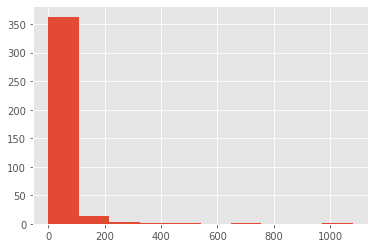

In [4]:
df.likes_memes.hist();

Мы видим тяжелый хвост. В данных куча выбросов. Мы уже умеем с этим бороться. 

__[0.5] Прологарифмируйте переменную и постройте для её логарифма гистограмму.__

In [5]:
df['likes_memes_lg'] = df.likes_memes.apply(lambda x: np.log(x+1))

Помните, в прошлый раз мы сталкивались с пропусками в данных? Давайте посмотрим, что насколько полные в этом плане у нас данные. 
Визуализируем табличку данных, раскрасим желтым цветом пропуски, фиолетовым - наблюдения. 

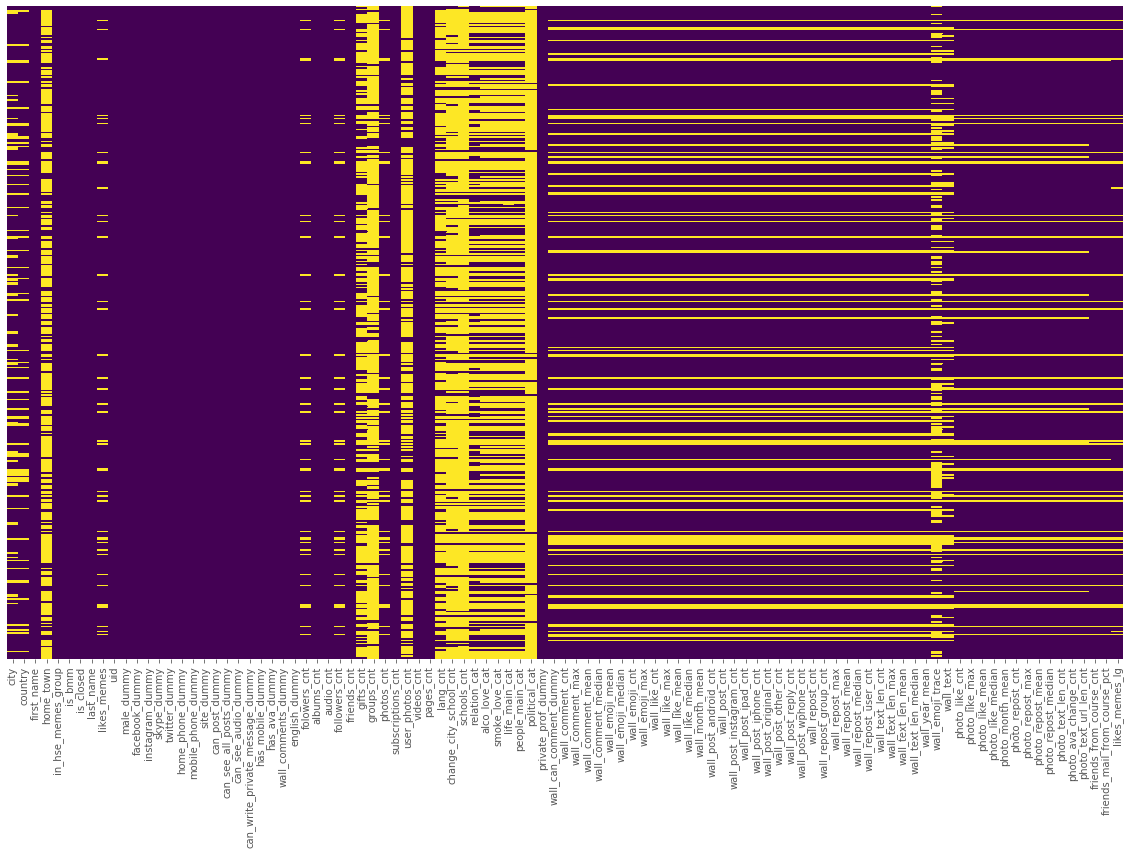

In [6]:
fig, ax = plt.subplots(figsize=(20,12))
sns_heatmap = sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

У нас есть целые столбцы желтого цвета, т.е. они не несут для нас информации (они же пустые). Очень большое число пропусков связано с приватностью странички (таких $82$). Давайте выкинем из рассмотрения все данные, где пропусков строго больше $82$ и все наблюдения, где предсказываемая переменная пустая. 

__[1] Сделайте это :)__

In [7]:
drop_cols = df.isna().sum().where(df.isna().sum()>82).dropna().index

In [8]:
drop_rows = df[df.likes_memes_lg.isna()].index

In [9]:
df = df.drop(drop_rows, axis=0).drop(drop_cols, axis=1)

Все переменные, которые есть в выборке делятся на несколько типов. Я специально постарался отразить их типы в названиях. Давайте посмотрим на то, какие это типы.

## 1.1 Переменные счётчики
Количество друзей, количество подписчиков, число фоток - всё это счётчики!

In [10]:
variables_cnt = [item for item in df.columns if item[-3:] == 'cnt']
variables_cnt[:5]

['folowers_cnt', 'albums_cnt', 'audio_cnt', 'followers_cnt', 'friends_cnt']

Давайте их визуализируем.

__[0.5] Постройте гистограммы для всех счётчиков__

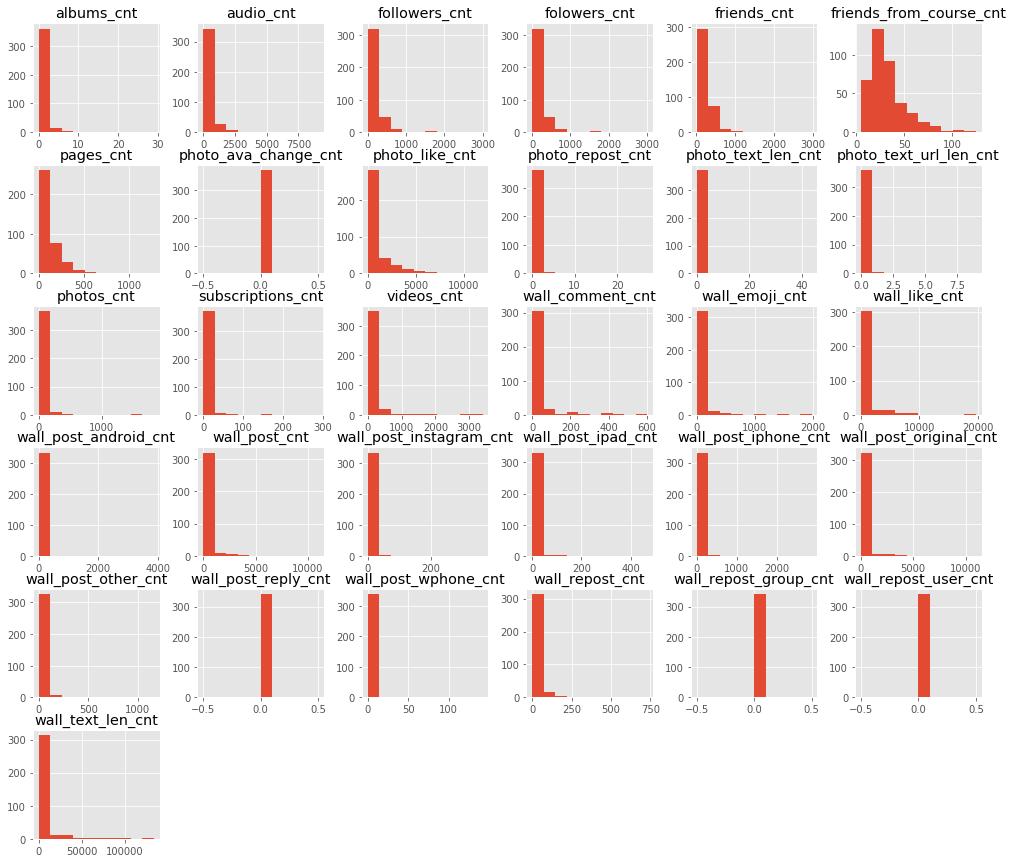

In [11]:
df[variables_cnt].hist(figsize=(17, 15))
plt.show()

Видим две вещи: 

* У многих счётчиков длинные хвосты => выбросы => придется их сглаживать.
* Многие счётчики не очень информативны: принимают одно или два значения => придется такие счётчики выбросить. 

In [12]:
print('Переменных-счётчиков до отбрасывания:', len(variables_cnt))

# Оставим только те счётчики, которые принимают больше 10 значений 
variables_cnt = [item for item in variables_cnt if len(df[item].unique()) > 10]

print('Переменных-счётчиков после отбрасывания:', len(variables_cnt))

Переменных-счётчиков до отбрасывания: 31
Переменных-счётчиков после отбрасывания: 23


Многие оставшиеся перемннные имеют тяжелые хвосты. Что мы с ними делаем? Правильно! Логарифмируем. 

__[1] Прологарифмируйте все счётчики и снова постройте для них гистограммы.__

In [13]:
list_vars = []
for i in variables_cnt:
    name = i + '_lg'
    df[name] = df[i].apply(lambda x: np.log(x + 1))
    list_vars.append(name)

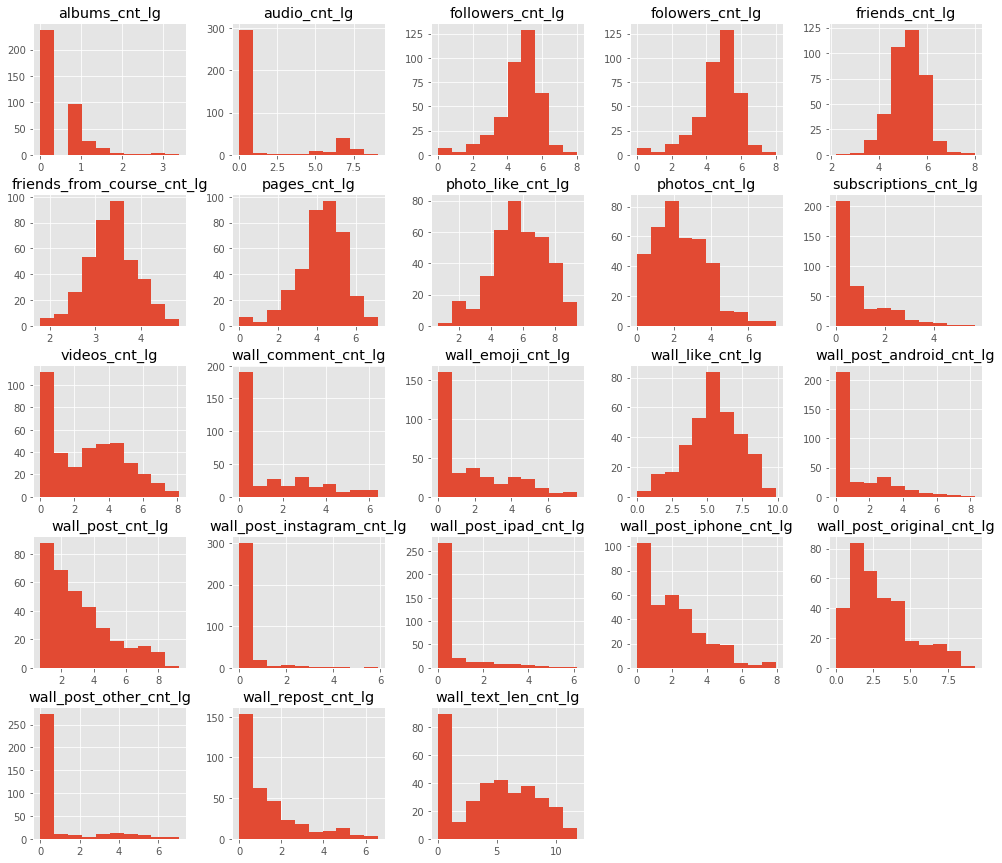

In [14]:
df[list_vars].hist(figsize=(17, 15))
plt.show()

## 1.2 Dummy - переменные
 
У нас также есть переменные, принимающие значения 0 или 1, давайте на них посмотрим.

In [15]:
variables_dummy = [item for item in df.columns if item[-5:] == 'dummy']
variables_dummy[:5]

['male_dummy',
 'facebook_dummy',
 'instagram_dummy',
 'skype_dummy',
 'twitter_dummy']

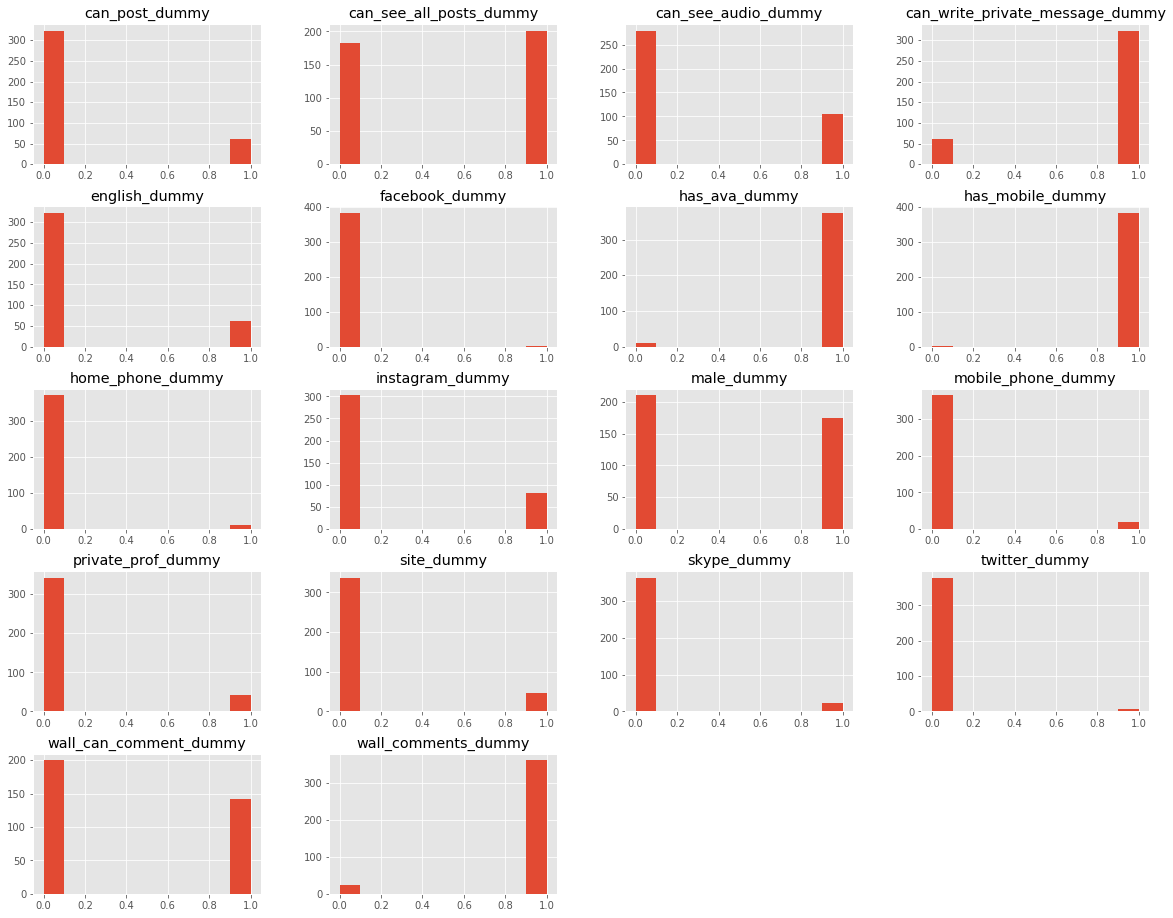

In [16]:
df[variables_dummy].hist(figsize=(20,16));

Есть несколько не очень информативных переменных. Например, наличие твиттера или указан ли телефон. Почти у всех там стоят нули. То есть твиттер и телефон не указаны. Можно было бы выкинуть эти переменные, но мы пожалуй не будем. 

## 1.3 Средние и медианы

Мы посчитали по каждому пользователю среднее число комментов на стене, среднее количество репостов, эмодзи и другие подобные характеристики. Давайте на них взглянем.

In [17]:
variables_mean = [item for item in df.columns if item[-4:] == 'mean']
variables_mean[:5]

['wall_comment_mean',
 'wall_emoji_mean',
 'wall_like_mean',
 'wall_month_mean',
 'wall_repost_mean']

In [18]:
variables_median = [item for item in df.columns if item[-6:] == 'median']
variables_median[:5]

['wall_comment_median',
 'wall_emoji_median',
 'wall_like_median',
 'wall_repost_median',
 'wall_text_len_median']

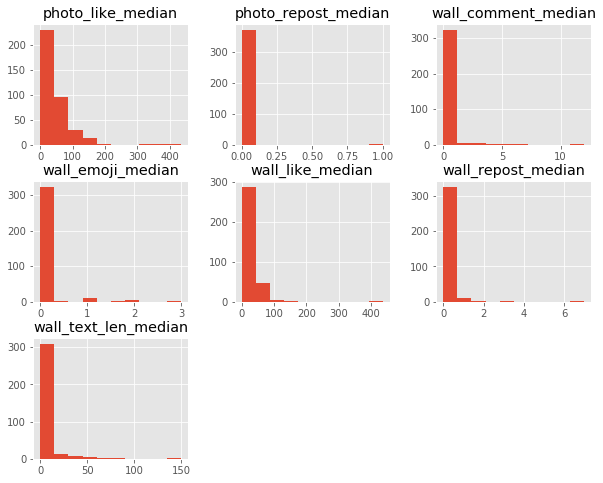

In [19]:
df[variables_median].hist(figsize=(10,8));

Как мы знаем, медиана и среднее могут быть сильно коррелированы, что плохо отражается на линейных моделях регрессии. Давайте посмотрим на матрицу корреляции и выберем один из способов агрегации.

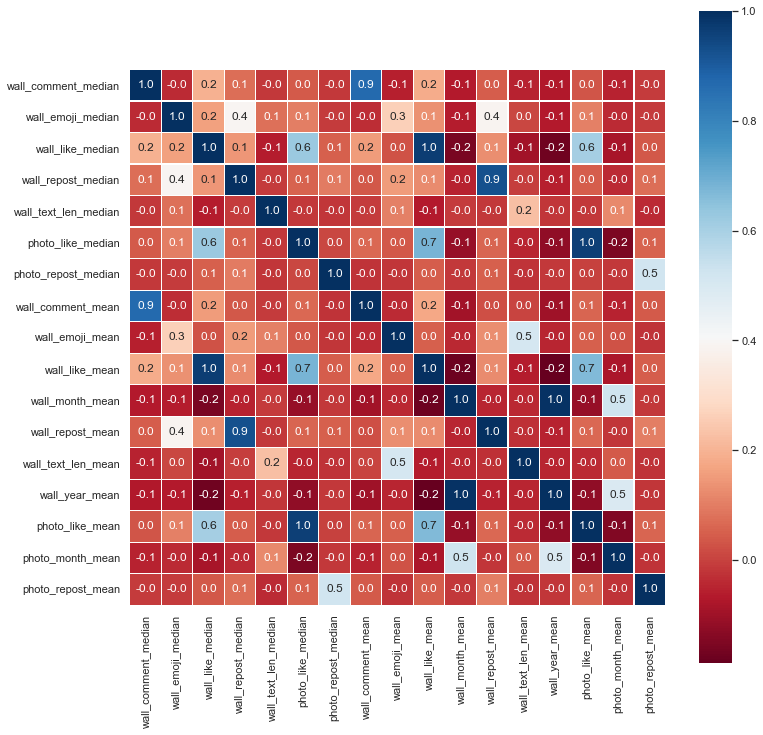

In [20]:
sns.set(font_scale=1)
plt.subplots(figsize=(12, 12))
sns.heatmap(df[variables_median + variables_mean].corr(), square=True,
              annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")

Давайте оставим медианы.

In [21]:
variables_descriptive = variables_median 
df[variables_descriptive] =  df[variables_descriptive].apply(lambda w: np.log(w + 1))

Соберем все оставшиеся переменные и заполним пропуски нулями.

In [22]:
useful_variables = variables_cnt + variables_dummy + variables_descriptive + ['friends_mail_from_course_pct']
df[useful_variables] = df[useful_variables].fillna(0)
df.head()

,country,first_name,in_hse_memes_group,is_bmm,is_closed,last_name,likes_memes,uid,male_dummy,facebook_dummy,...,wall_post_cnt_lg,wall_post_instagram_cnt_lg,wall_post_ipad_cnt_lg,wall_post_iphone_cnt_lg,wall_post_original_cnt_lg,wall_post_other_cnt_lg,wall_repost_cnt_lg,wall_text_len_cnt_lg,photo_like_cnt_lg,friends_from_course_cnt_lg
0,Россия,Александра,True,True,False,Абашкова,60.0,182152789,0,0,...,3.526361,0.0,0.00000,3.496508,3.526361,0.000000,0.693147,5.241747,5.736572,3.761200
1,Россия,Анастасия,True,True,False,Чуфистова,0.0,148020433,0,0,...,7.165493,0.0,1.94591,3.871201,6.232448,6.666957,5.552960,11.544017,7.970740,3.496508
2,Россия,Александр,False,True,False,Головачев,0.0,138413935,1,0,...,1.098612,0.0,0.00000,1.098612,1.098612,0.000000,1.386294,4.430817,7.786136,3.496508
3,NaN,Анна,False,True,False,Лобанова,0.0,366261055,0,0,...,2.944439,0.0,0.00000,2.890372,2.944439,0.000000,0.000000,8.629450,7.178545,3.828641
4,Россия,Алексей,True,True,False,Пузырный,21.0,111252392,1,0,...,3.610918,0.0,0.00000,1.609438,3.610918,0.000000,1.945910,7.894318,7.226936,3.737670


## 1.4 Категориальные переменные 

Название говорит само за себя. 

In [23]:
variables_cat = [item for item in df.columns if item[-3:] == 'cat']
variables_cat[:5]

[]

В данных их нет. Но на семинаре были. __И на экзамене обязательно будут.__ Посмотрите ещё раз в семинаре как с ними необходимо работать. 

# 2. Разбиение выборки

__[1] Разбейте выборку на трэйн и тест. Объясните зачем так делать своими словами.__ 

In [49]:
from sklearn.model_selection import train_test_split

In [50]:
df_train, df_test = train_test_split(df, train_size=0.8, random_state=42)

__[1] Объясните зачем выборку разбивают на тренировочную и тестовую__

__Ответ:__ Казалось бы, если мы используем все данные, то модель может лучше обучиться. Но модель может стать очень сложной и потерять качество - переобучение. Таким образом, на тренировочной выборке модель только учится, а на тестовой проверяет своё качество. Повод для беспокойства появляется, когда модель плоха на тестовой выборке, хотя на тренировочной у неё высокие показатели качества.

# 3. Моделирование

##  3.1 Наивный константный прогноз

__[1] Постройте константный прогноз. В качестве прогноза используйте медиану.__

In [57]:
median_pred = np.median(df_train.likes_memes_lg)
median_pred

1.3862943611198906

In [58]:
print('среднее =', np.mean(df_train.likes_memes_lg))

среднее = 1.638497914763927


__[1] Чем медиана лучше среднего? Почему её логичнее использовать для константного прогноза?__

__Ответ:__ Среднее чувствительно к выбросам. К примеру, среднее население городов миллионников будет чуть выше 2 млн., но города с таким населением не существует, сильно влияет Москва и СпБ. А медиана делит данные на две равные группы и устойчива к выбросам. Логичнее использовать медиану, так как в наших данных есть высокие значения, которые завышают арифметическое среднее.

Теперь давайте посмотрим на тестовой выборке насколько константный прогноз получился хорошим. Будем использовать в качестве метрики качества $MAE$. Подгрузите метрику из `sklearn` и выясните качество работы константного прогноза на тестовой выборке. За вдохновением можно снова обратиться к семинару, но не вздумайте переписывать один в один функцию print_metrics. За это буду отнимать баллы.

__[1] Найдите MAE константного прогноза.__

In [59]:
from sklearn.metrics import mean_absolute_error

In [60]:
y_test = df_test.likes_memes_lg
def find_mae(pred):
    print(f'MAE = {mean_absolute_error(pred, y_test)}')

In [61]:
median_array = np.full((df_test.shape[0], 1), median_pred)

In [62]:
find_mae(median_array)

MAE = 1.5663295707252067


Отлично! Теперь у нас есть с чем сравнить более сложные модели. Давайте займёмся их строительством.

##  3.2 Линейная регрессия

Давайте оставим для работы только те переменные, которые сильнее всего коррелируют с таргетом. Вот так это можно сделать для топ-10 положительных переменных:

In [63]:
corr_pos =  df_train[useful_variables].corrwith(df_train['likes_memes_lg']).sort_values(ascending=False)
corr_pos[:10]

instagram_dummy           0.151039
wall_post_original_cnt    0.144308
english_dummy             0.134012
wall_post_iphone_cnt      0.132968
wall_like_cnt             0.129113
wall_post_cnt             0.127138
photos_cnt                0.112917
videos_cnt                0.099563
wall_comments_dummy       0.098518
has_ava_dummy             0.096333
dtype: float64

__[2] Запишите в переменную corr_neg топ-10 переменных с негативной корреляцией, запишите их в `corr_neg`.__

In [64]:
corr_neg =  df_train[useful_variables].corrwith(df_train['likes_memes_lg']).sort_values(ascending=True)
corr_neg[:10]

male_dummy                     -0.124678
wall_post_other_cnt            -0.112942
can_see_all_posts_dummy        -0.110691
friends_mail_from_course_pct   -0.083022
wall_can_comment_dummy         -0.080135
mobile_phone_dummy             -0.078316
wall_text_len_median           -0.077596
photo_repost_median            -0.060529
facebook_dummy                 -0.060529
subscriptions_cnt              -0.057685
dtype: float64

Оставляем только коррелируемые переменные.

In [65]:
# оставляем в выборке только самые важные переменные 
best_variables = list(corr_pos[:10].index) + list(corr_neg[:10].index)

# Забираем в выборку лучших из лучших 
X_train = df_train[best_variables].to_numpy()
X_test = df_test[best_variables].to_numpy()

In [66]:
y_train = df_train.likes_memes_lg
y_test = df_test.likes_memes_lg

Теперь давайте наконец обучим на отобранных признаках линейную регрессию.

__[2] Оцените линейную регрессию. Посмотрите на её MAE на тестовой выборке.__

Постройте для неё с помощью функции `plot_yreal_ypred`, которую мы объявили в начале тетрадки, визуализацию её прогнозов. Сравните качество модели с константным прогнозом.

In [67]:
from sklearn.linear_model import LinearRegression

In [68]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

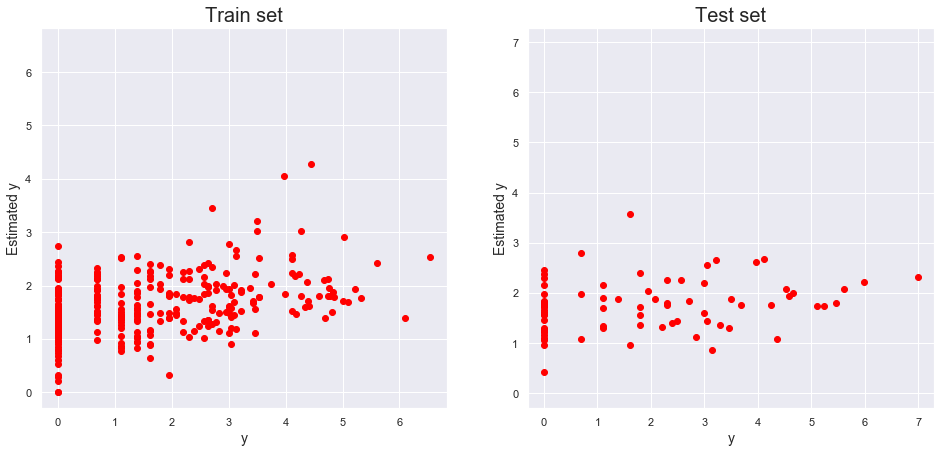

In [69]:
plot_yreal_ypred(y_test, y_train, X_test, X_train, lin_model)

In [70]:
find_mae(lin_model.predict(X_test))

MAE = 1.5037453781016803


__[1] Что видно по построенной картинке? Сделайте выводы о работоспособности модели.__

__Ответ:__ Однозначно, модель плохая. Видим, что для нулевых значений модель предсказывала даже больше 10 ** 2, а для высоких значений, она показывала заниженные результаты. На тестовой выборке такой же плохой результат. Мы должны были видеть прямую диагональную линию для хорошей модели.

## 3.3 Решающее дерево

__[2]__ Теперь давайте оценим решающее дерево. Подгрузите из модуля `sklearn.tree` модель `DecisionTreeRegressor`.

Объявите один экземпляр модели. У любой модели, которую вы оцениваете есть довольно много различных параметров. Зафикисруйте для дерева следуюшие значения параметров: 

```
    random_state = 42,
    max_depth = 30,
    criterion = "mae",
```

Оцените модель на тренировочной выборке.

In [39]:
from sklearn.tree import DecisionTreeRegressor

In [40]:
tree_model = DecisionTreeRegressor(criterion='mae', max_depth=30, random_state=42)
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=30,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [41]:
# train MAE
mean_absolute_error(tree_model.predict(X_train), y_train)

0.0

In [42]:
# test MAE
find_mae(tree_model.predict(X_test))

MAE = 1.738321979894798


__[1] Опишите что означают выбранные нами гиперпараметры. Прочитать об этом можно в [документации](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)__

__Ответ:__ random_state фиксирует состояние, чтобы код воспроизводился всегда одинаково. Критерий "mae" говорит использовать MAE для вычисления качества деления, и модель делит лист, чтобы MAE был минимальным. max_depth - максимальная глубина дерева. То есть длина от корня к самому дальнему листу.

__[1] Примените полученную модель на тестовой выборке. Каким оказалась MAE? Больше или меньше, чем у линейной регресси? Постройте для неё с помощью функции `plot_yreal_ypred`, которую мы объявили в начале тетрадки, визуализацию её прогнозов.__


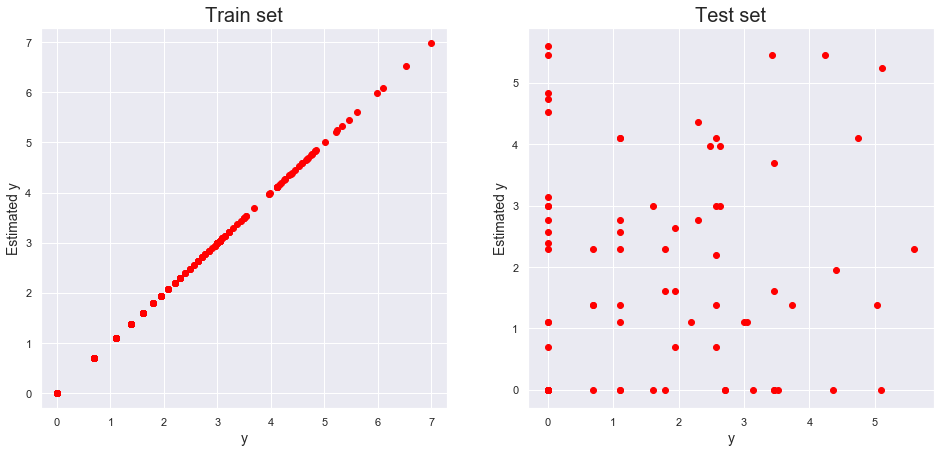

In [43]:
plot_yreal_ypred(y_test, y_train, X_test, X_train, tree_model)

In [77]:
print('Отличие среднего предсказания от реального значения =', np.e ** 1.5)

Отличие среднего предсказания от реального значения = 4.4816890703380645


__[1] Какие модель оказалась лучшей? Побила ли она константный прогноз? Какие выводы можно сделать из визуализаций?__


__Ответ:__ Лучшей оказалась модель с линейной регрессией. Но она несильно отличается от константного прогноза. Дерево решений переобучилось, линейная модель предсказывает значения, в основном, от 0 до 3 (от 0 до 20 при пересчёте). И плохо предсказывает значения выше 3.


__[1] Опишите что бы происходило на картинке, если бы модель переобучилась? Что происходило бы, если бы она получилась хорошей? Почему картинка выглядела бы именно так?__ 


__Ответ:__ Переобучение произошло у дерева решений. Идеальное совпадение реальных данных с предсказанными на тренировочной выборке, но полный хаос на тестовых данных, модель не уловила закономерности, а просто запомнила данные. Если бы получилась хорошей, тогда на тестовых данных мы тоже должны были видеть линию (желательно как можно более прямую по диагонали). 


__[1] Как считате, удалось ли нам научиться предсказывать, сколько лайков студент первого курса поставит в паблик? С чем это на ваш взгляд связано?__

__Ответ:__ Нет, не удалось. Линейная модель лишь слегка лучше константного прогноза, значит алгоритмы слабо могут повлият на прогноз. Предсказание, в среднем, отклоняется от реального значения в 4.5 раз, это плохой результат. Связано с тем, что модели чувствительны к выбросам (нули и высокие значения), которых немало. Также мало влиятельных предикторов. Максимальная корреляция - 0.15, это очень мало. Модель вряд ли станет много лучше от другого алгоритма, но сбор дополнительных данных мог бы поспособствовать улучшению результатов.
 

Настрадался? Выскажи всё, что думаешь обо всём этом [в анонимке по пятому дз.](https://docs.google.com/forms/d/e/1FAIpQLSfqW8UBNNSQbqSm_y6pmoQdXi595iyDRkB66KuxXfmOjbxCaw/viewform) 